In [1]:
# Self-Compressing Neural Networks https://arxiv.org/abs/2301.13142

In [1]:
import math
import operator
from itertools import cycle
from functools import reduce
from tqdm import trange

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 2
LR = 3e-4
TRAINING_STEPS = 10000
GAMMA = 0.7

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [7]:
train_loader = cycle(train_loader)

In [8]:
def cast_tuple(t, length = 1):
    return t if isinstance(t, tuple) else ((t,) * length)

def prod(x):
    return reduce(operator.mul, x, 1)

In [ ]:
class QConv2d(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.kernel_size = cast_tuple(kernel_size, length=2) # (height, width)
        # He initialization for stable weight distributions
        # TODO rewrite https://discuss.pytorch.org/t/what-is-the-default-initialization-of-a-conv2d-layer-and-linear-layer/16055/2
        scale = 1 / math.sqrt(in_channels * prod(self.kernel_size))
        self.weight = nn.Parameter(torch.FloatTensor(out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
        # controls weight scaling
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
        # determines bit-width for quantization (2 bits by default)
        # i.e. how many discrete levels the weights can take. higher b allows more precise weight representation.
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), 2.))


    def qbits(self): # equation 4
        # compute the total number of quantized bits used in the layer.
        # sum across output channel
        return F.relu(self.b).sum() * prod(self.weight.shape[1:])

    def qweight(self): # equation 1

        # quantize wiegths via differentiable min-max scaling (rounding happens in forward pass)
        out = torch.minimum(
            torch.maximum(
                2**-self.e * self.weight,
                -2**(F.relu(self.b)-1) # lower bound, relu ensures that b is always positive
            ),
            2**(F.relu(self.b)-1) - 1 # upper bound, relu ensures that b is always positive
        )
        # initially, weights are constrained to: [-2, -1, 0, 1, 2]
        return out

    def forward(self, x):
        qw = self.qweight() # quantized weight (independent of input tensor) (equation 1 cont.)
        # straight through estimator (STE)
        #   torch.round(qw): quantised weight
        #   detach() := prevents gradients from flowing through torch.round(qw) - qw.
        #   forces the gradient computation to ignore rounding.
        #   gradient behaves as if the operation was an identity function.
        w = (torch.round(qw) - qw).detach() + qw
        w = 2**self.e * w
        return F.conv2d(x, weight=w)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = QConv2d(1, 32, 5)
        self.conv2 = QConv2d(32, 32, 5)
        self.conv3 = QConv2d(32, 64, 3)
        self.conv4 = QConv2d(64, 64, 3)

        self.bnorm1 = nn.BatchNorm2d(32, affine=False, track_running_stats=False)
        self.bnorm2 = nn.BatchNorm2d(64, affine=False, track_running_stats=False)

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.final_conv = QConv2d(576, 10, 1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.bnorm1(out)
        out = self.maxpool1(out)

        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.bnorm2(out)
        out = self.maxpool2(out)

        out = torch.flatten(out, 1).reshape(-1, 576, 1, 1) # 576 in channels, 10 out channels
        out = self.final_conv(out)

        out = torch.flatten(out, 1)
        return out

In [31]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss = nn.CrossEntropyLoss()

# compression factor (determines compression vs accuracy)
gamma = 0.05
# the total number of weights N in the starting network
n = sum(t.numel() for t in model.parameters())


In [32]:
def train_step(data, target):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    # lambda(x)= lambda_0(x) + gamma * Q (equation 2)
    #   lambda_0(x) := cross-entropy loss
    #   gamma := compression factor
    #   Q := average bit depth
    loss = F.cross_entropy(output, target)
    q = reduce(lambda x,y: x+y, [layer.qbits() for layer in model.modules() if isinstance(layer, QConv2d)]) / n # (equation 3)
    loss = loss + gamma * q
    loss.backward()
    optimizer.step()
    return loss, q

In [33]:
def test(model, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # index of max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset) * 100
    return test_loss, acc

In [34]:
model.to(device)

Net(
  (conv1): QConv2d()
  (conv2): QConv2d()
  (conv3): QConv2d()
  (conv4): QConv2d()
  (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (final_conv): QConv2d()
)

In [35]:
test_losses, test_accs, bytes_used = [], [], []
test_acc = float("nan")

# epochs = training steps / batch size
for i in (t:=trange(1, TRAINING_STEPS + 1)):

    data, target = next(train_loader)

    loss, q = train_step(data, target)

    model_bytes = q.item() / 8 * n

    if i % 10 == 9:
        test_loss, test_acc = test(model, test_loader)

        test_losses.append(test_loss)
        test_accs.append(test_acc)
        bytes_used.append(model_bytes)

        model.train()

    t.set_description(f"loss: {loss.item():6.2f}  bytes: {model_bytes:.1f}  acc: {test_acc:5.2f}%")


loss:   0.18  bytes: 21574.7  acc: 98.10%: 100%|██████████| 10000/10000 [22:29<00:00,  7.41it/s]


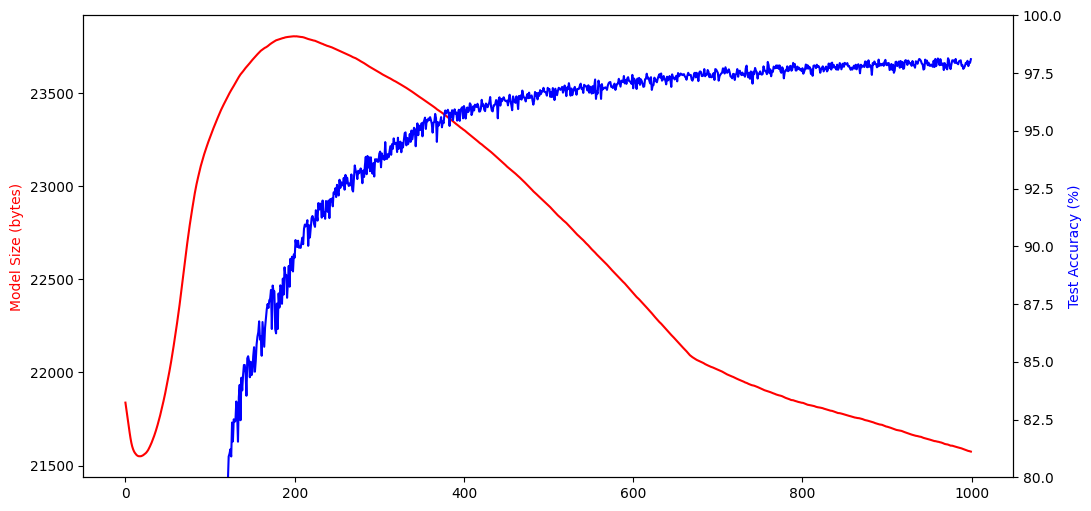

In [36]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel("Model Size (bytes)")
ax1.yaxis.label.set_color("red")
ax1.plot(bytes_used, color="red")
ax2 = ax1.twinx()
ax2.plot(test_accs, color="blue")
plt.ylim(80, 100)
ax2.set_ylabel("Test Accuracy (%)")
ax2.yaxis.label.set_color("blue")